In [1]:
%matplotlib notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy as sp
from scipy import sparse

import sklearn
import sklearn.mixture
from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
import os

import openTSNE
from openTSNE import TSNE
from openTSNE import affinity, initialization, TSNEEmbedding

import time

import pickle

from scipy.stats import gaussian_kde

from sklearn.neighbors import NearestNeighbors

import umap
import numba
import pynndescent 

import memory_profiler
%load_ext memory_profiler

# Truncated SVD

In [3]:
tfidf_features = sp.sparse.load_npz("variables/tfidf_features.npz")

In [3]:
%%time
%%memit

#TruncatedSVD
svd = TruncatedSVD(n_components=300,random_state=42,algorithm='arpack')
svd_data=svd.fit_transform(tfidf_features)

# save results
np.save("variables/svd_data",svd_data)

peak memory: 228102.69 MiB, increment: 203097.80 MiB
CPU times: user 19h 3min 34s, sys: 2h 53min 34s, total: 21h 57min 8s
Wall time: 4h 27min 20s


# t-SNE

In [2]:
# svd transformed data
svd_data=np.load("variables/svd_data.npy")

## Uniform affinities

In [ ]:
%%time

A = affinity.Uniform(svd_data, k_neighbors=10, n_jobs=-1, verbose=1, random_state=42)

===> Finding 10 nearest neighbors using Annoy approximate search using euclidean distance...


In [ ]:
f = open("variables/affinities_k_10.pkl","wb")
pickle.dump(A,f)
f.close()

In [ ]:
# #load affinities
# pickle_in = open("variables/affinities_k_10.pkl","rb")
# A = pickle.load(pickle_in)

## Default, exgg=1, n_iter=10000

In [4]:
Zs = []
kls = []
n_iter = []

def mycallback(iteration, error, embedding):
    Zs.append(embedding.copy())
    kls.append(error)
    n_iter.append(iteration)

In [ ]:
%%time
%%memit

I = initialization.pca(svd_data, random_state=42)

E = TSNEEmbedding(I, A, n_jobs=-1, random_state=42, verbose=True)

n = svd_data.shape[0]

# early exaggeration
E = E.optimize(n_iter=250, exaggeration=12, momentum=0.5, n_jobs=-1, learning_rate = n/12, verbose=True, callbacks=mycallback, callbacks_every_iters=50)

# final optimization without exaggeration
E = E.optimize(n_iter=10000, exaggeration=1, momentum=0.8, n_jobs=-1, learning_rate = n/12, verbose=True, callbacks=mycallback, callbacks_every_iters=50)

===> Running optimization with exaggeration=12.00, lr=1584692.33 for 250 iterations...
Iteration   50, KL divergence 13.8228, 50 iterations in 291.4892 sec
Iteration  100, KL divergence 12.9131, 50 iterations in 304.8527 sec
Iteration  150, KL divergence 12.7614, 50 iterations in 310.1128 sec
Iteration  200, KL divergence 12.7425, 50 iterations in 296.4483 sec
Iteration  250, KL divergence 12.7381, 50 iterations in 314.2542 sec
   --> Time elapsed: 1517.16 seconds
===> Running optimization with exaggeration=1.00, lr=1584692.33 for 10000 iterations...
Iteration   50, KL divergence 10.9058, 50 iterations in 289.6407 sec
Iteration  100, KL divergence 10.2121, 50 iterations in 289.6920 sec
Iteration  150, KL divergence 9.8265, 50 iterations in 304.8080 sec
Iteration  200, KL divergence 9.5740, 50 iterations in 318.7076 sec
Iteration  250, KL divergence 9.3936, 50 iterations in 345.1418 sec
Iteration  300, KL divergence 9.2573, 50 iterations in 364.4962 sec
Iteration  350, KL divergence 9.1

In [ ]:
Zs_array=[]
for i in np.arange(len(Zs)):
    Zs_array.append(np.array(Zs[i]))

In [ ]:
#save results
f = open("variables/all_data/tsne_exgg_1_n_iter_10000/Zs_array.pkl","wb")
pickle.dump(Zs_array,f)
f.close()

In [ ]:
#save iter
f = open("variables/all_data/tsne_exgg_1_n_iter_10000/iterations.pkl","wb")
pickle.dump(n_iter,f)
f.close()

In [ ]:
#save kls
f = open("variables/all_data/tsne_exgg_1_n_iter_10000/kl_divergence.pkl","wb")
pickle.dump(kls,f)
f.close()

In [ ]:
tsne=np.array(E)

#save
np.save("variables/all_data/tsne_exgg_1_n_iter_10000/tsne", tsne)

## Annealing, exgg=1, n_iter=10000 

In [6]:
Zs = []
kls = []
n_iter = []

def mycallback(iteration, error, embedding):
    Zs.append(embedding.copy())
    kls.append(error)
    n_iter.append(iteration)

In [ ]:
%%time
%%memit

I = initialization.pca(svd_data, random_state=42)

E = TSNEEmbedding(I, A, n_jobs=-1, random_state=42, verbose=True)

# early exaggeration
E = E.optimize(n_iter=125, exaggeration=12, momentum=0.5, n_jobs=-1, verbose=True, callbacks=mycallback, callbacks_every_iters=50)

# exaggeration annealing
exs = np.linspace(12,1,125)
n = svd_data.shape[0]
for i in range(125):
    if (i+1)%50 == 0:
        E = E.optimize(n_iter=1, exaggeration=exs[i], momentum=0.8, n_jobs=-1, verbose=True, callbacks=mycallback, callbacks_every_iters=1)
        
    else:
        E = E.optimize(n_iter=1, exaggeration=exs[i], momentum=0.8, n_jobs=-1, verbose=True)
    
# final optimization without exaggeration
E = E.optimize(n_iter=10000, exaggeration=1, momentum=0.8, n_jobs=-1, verbose=True, callbacks=mycallback, callbacks_every_iters=50)

===> Running optimization with exaggeration=12.00, lr=1584692.33 for 125 iterations...
Iteration   50, KL divergence 13.8228, 50 iterations in 276.8350 sec
Iteration  100, KL divergence 12.9131, 50 iterations in 285.3435 sec
   --> Time elapsed: 708.75 seconds
===> Running optimization with exaggeration=12.00, lr=1584692.33 for 1 iterations...
   --> Time elapsed: 5.55 seconds
===> Running optimization with exaggeration=11.91, lr=1584692.33 for 1 iterations...
   --> Time elapsed: 5.01 seconds
===> Running optimization with exaggeration=11.82, lr=1584692.33 for 1 iterations...
   --> Time elapsed: 6.50 seconds
===> Running optimization with exaggeration=11.73, lr=1584692.33 for 1 iterations...
   --> Time elapsed: 5.12 seconds
===> Running optimization with exaggeration=11.65, lr=1584692.33 for 1 iterations...
   --> Time elapsed: 5.70 seconds
===> Running optimization with exaggeration=11.56, lr=1584692.33 for 1 iterations...
   --> Time elapsed: 5.67 seconds
===> Running optimization

In [ ]:
Zs_array=[]
for i in np.arange(len(Zs)):
    Zs_array.append(np.array(Zs[i]))

In [ ]:
#save results
f = open("variables/all_data/tsne_annealing_exgg_1_n_iter_10000/Zs_array.pkl","wb")
pickle.dump(Zs_array,f)
f.close()

In [ ]:
#save iter
f = open("variables/all_data/tsne_annealing_exgg_1_n_iter_10000/iterations.pkl","wb")
pickle.dump(n_iter,f)
f.close()

In [ ]:
#save kl divergence
f = open("variables/all_data/tsne_annealing_exgg_1_n_iter_10000/kl_divergence.pkl","wb")
pickle.dump(kls,f)
f.close()

In [ ]:
tsne=np.array(E)

#save
np.save("variables/all_data/tsne_annealing_exgg_1_n_iter_10000/tsne", tsne)

## Default, exgg=2, n_iter=2000

In [6]:
Zs = []
kls = []
n_iter = []

def mycallback(iteration, error, embedding):
    Zs.append(embedding.copy())
    kls.append(error)
    n_iter.append(iteration)

In [ ]:
%%time

I = initialization.pca(svd_data, random_state=42)

E = TSNEEmbedding(I, A, n_jobs=-1, random_state=42, verbose=True)

n = svd_data.shape[0]

# early exaggeration
E = E.optimize(n_iter=250, exaggeration=12, momentum=0.5, n_jobs=-1, learning_rate = n/12, verbose=True, callbacks=mycallback, callbacks_every_iters=50)

# final optimization without exaggeration
E = E.optimize(n_iter=2000, exaggeration=2, momentum=0.8, n_jobs=-1, learning_rate = n/12, verbose=True, callbacks=mycallback, callbacks_every_iters=50)

In [ ]:
Zs_array=[]
for i in np.arange(len(Zs)):
    Zs_array.append(np.array(Zs[i]))

In [ ]:
#save results
f = open("variables/all_data/tsne_exgg_2_n_iter_2000/Zs_array.pkl","wb")
pickle.dump(Zs_array,f)
f.close()

In [ ]:
#save iter
f = open("variables/all_data/tsne_exgg_2_n_iter_2000/iterations.pkl","wb")
pickle.dump(n_iter,f)
f.close()

In [ ]:
#save kl divergence
f = open("variables/all_data/tsne_exgg_2_n_iter_2000/kl_divergence.pkl","wb")
pickle.dump(kls,f)
f.close()

In [ ]:
tsne=np.array(E)

#save
np.save("variables/all_data/tsne_exgg_2_n_iter_2000/tsne", tsne)

## Default, exgg=4, n_iter=2000

In [6]:
Zs = []
kls = []
n_iter = []

def mycallback(iteration, error, embedding):
    Zs.append(embedding.copy())
    kls.append(error)
    n_iter.append(iteration)

In [ ]:
%%time
%%memit

#mio bueno

I = initialization.pca(svd_data_300_arpack, random_state=42)

E = TSNEEmbedding(I, A, n_jobs=-1, random_state=42, verbose=True)

n = svd_data_300_arpack.shape[0]

# early exaggeration
E = E.optimize(n_iter=250, exaggeration=12, momentum=0.5, n_jobs=-1, learning_rate = n/12, verbose=True, callbacks=mycallback, callbacks_every_iters=50)

# final optimization without exaggeration
E = E.optimize(n_iter=2000, exaggeration=4, momentum=0.8, n_jobs=-1, learning_rate = n/12, verbose=True, callbacks=mycallback, callbacks_every_iters=50)

In [ ]:
Zs_array=[]
for i in np.arange(len(Zs)):
    Zs_array.append(np.array(Zs[i]))

In [ ]:
#save results
f = open("variables/all_data/tsne_exgg_4_n_iter_2000/Zs_array.pkl","wb")
pickle.dump(Zs_array,f)
f.close()

In [ ]:
#save iter
f = open("variables/all_data/tsne_exgg_4_n_iter_2000/iterations.pkl","wb")
pickle.dump(n_iter,f)
f.close()

In [ ]:
#save kl divergence
f = open("variables/all_data/tsne_exgg_4_n_iter_2000/kl_divergence.pkl","wb")
pickle.dump(kls,f)
f.close()

In [ ]:
tsne=np.array(E)

#save
np.save("variables/all_data/tsne_exgg_4_n_iter_2000/tsne", tsne)

# Plots

## Import data

In [6]:
tsne_annealing_exgg_1_n_iter_10000=np.load("variables/all_data/tsne_annealing_exgg_1_n_iter_10000/tsne.npy")
tsne_exgg_1_n_iter_10000=np.load("variables/all_data/tsne_exgg_1_n_iter_10000/tsne.npy")
tsne_exgg_2_n_iter_2000=np.load("variables/all_data/tsne_exgg_2_n_iter_2000/tsne.npy")
tsne_exgg_4_n_iter_2000=np.load("variables/all_data/tsne_exgg_4_n_iter_2000/tsne.npy")

In [6]:
pickle_in = open("variables/all_data/tsne_annealing_exgg_1_n_iter_10000/Zs_array.pkl","rb")
Zs_array_annealing_exgg_1 = pickle.load(pickle_in)

iterations=np.load("variables/all_data/tsne_exgg_1_n_iter_10000/iterations.npy")

In [63]:
#colors
automatic_colors=np.load("variables/new_colors.npy", allow_pickle=True)

# legend colors
pickle_in = open("variables/new_colors_legend.pkl","rb")
automatic_legend = pickle.load(pickle_in)


In [57]:
# save
colors_per_year = np.load("variables/colors_per_year.npy")

# Functions and extra for plotting

In [7]:
"""
Description of colors and words below.

Colors:
-chosen_colors: Scanpy colors selection (originally from http://godsnotwheregodsnot.blogspot.com/2013/11/kmeans-color-quantization-seeding.html)

Words:
-words_capital: Words selected manually from the 100 most relevant words using threshold 0.1.
                They start with capital letter.

-words_small: Words selected manually from the 100 most relevant words using threshold 0.1.
                They are all in small letters.
"""

# COLORS
chosen_colors = ['black', '#FFFF00', '#1CE6FF', '#FF34FF', '#FF4A46', '#008941', '#006FA6', '#A30059', '#7A4900', '#0000A6', 
                 '#63FFAC', '#B79762', '#004D43', '#8FB0FF', '#D16100', '#5A0007', '#BA0900', '#1B4400', '#4FC601', '#3B5DFF', '#00C2A0']


# WORDS
words_capital=['Cancer', 'Neuroscience', 'Cardiology', 'Ecology', 'Bioinformatics','Chemistry', 'Surgery',
               'Biology', 'Environmental', 'Material', 
               'Cell', 'Microbiology', 'Pediatric', 'Immunology', 'Food',
               'Psychology','Psychiatry', 'Genetics', 'Nutrition', 'Veterinary',
               'Engineering'] 

words_small=[' cancer', ' neuroscience', ' cardiology', ' ecology', ' bioinformatics',' chemistry', ' surgery',
               ' biology', ' environmental', ' material', 
               ' cell', ' microbiology', ' pediatric', ' immunology', ' food',
               ' psychology',' psychiatry', ' genetics', ' nutrition', ' veterinary',
               ' engineering']

In [44]:
# Obtained from: https://github.com/berenslab/ne-spectrum/blob/master/jnb_msc/plot/scalebars.py

from matplotlib.offsetbox import AnchoredOffsetbox
from matplotlib.patches import Rectangle, FancyArrowPatch
from matplotlib.offsetbox import (
    AuxTransformBox,
    VPacker,
    HPacker,
    TextArea,
    DrawingArea,
)

class AnchoredScaleBar(AnchoredOffsetbox):
    def __init__(
        self,
        transform,
        sizex=0,
        sizey=0,
        labelx=None,
        labely=None,
        loc=4,
        pad=0.1,
        borderpad=0.1,
        sep=2,
        prop=None,
        barcolor="black",
        barwidth=0.4,
        **kwargs
    ):
        """
        Draw a horizontal and/or vertical  bar with the size in data coordinate
        of the give axes. A label will be drawn underneath (center-aligned).
        - transform : the coordinate frame (typically axes.transData)
        - sizex,sizey : width of x,y bar, in data units. 0 to omit
        - labelx,labely : labels for x,y bars; None to omit
        - loc : position in containing axes
        - pad, borderpad : padding, in fraction of the legend font size (or prop)
        - sep : separation between labels and bars in points.
        - **kwargs : additional arguments passed to base class constructor
        """
        bars = AuxTransformBox(transform)
        if sizex:
            arr = FancyArrowPatch(
                (0, 0),
                (sizex, 0),
                shrinkA=0,
                shrinkB=0,
                ec=barcolor,
                lw=barwidth,
                fc="none",
                arrowstyle="|-|",
            )
            arr.set_capstyle("butt")

            bars.add_artist(arr)

        if sizey:
            bars.add_artist(
                Rectangle((0, 0), 0, sizey, ec=barcolor, lw=barwidth, fc="none")
            )

        if sizex and labelx:
            self.xlabel = TextArea(labelx)
            bars = VPacker(children=[bars, self.xlabel], align="center", pad=0, sep=sep)
        if sizey and labely:
            self.ylabel = TextArea(labely)
            bars = HPacker(children=[self.ylabel, bars], align="center", pad=0, sep=sep)

        AnchoredOffsetbox.__init__(
            self,
            loc,
            pad=pad,
            borderpad=borderpad,
            child=bars,
            prop=prop,
            frameon=False,
            **kwargs
        )


def add_scalebar(ax, matchx=True, matchy=True, hidex=True, hidey=True, **kwargs):
    """Add scalebars to axes
    Adds a set of scale bars to *ax*, matching the size to the ticks of the plot
    and optionally hiding the x and y axes
    - ax : the axis to attach ticks to
    - matchx,matchy : if True, set size of scale bars to spacing between ticks
                    if False, size should be set using sizex and sizey params
    - hidex,hidey : if True, hide x-axis and y-axis of parent
    - **kwargs : additional arguments passed to AnchoredScaleBars
    Returns created scalebar object
    """

    def f(axis):

        l = axis.get_majorticklocs()
        return len(l) > 1 and (l[1] - l[0])

    if matchx:
        kwargs["sizex"] = f(ax.xaxis)
        kwargs["labelx"] = str(kwargs["sizex"])
    if matchy:
        kwargs["sizey"] = f(ax.yaxis)
        kwargs["labely"] = str(kwargs["sizey"])

    sb = AnchoredScaleBar(ax.transData, **kwargs)
    ax.add_artist(sb)

    if hidex:
        ax.xaxis.set_visible(False)
    if hidey:
        ax.yaxis.set_visible(False)
    if hidex and hidey:
        ax.set_frame_on(False)

    return sb


def add_scalebar_frac(ax, frac_len=0.125, eps=0.5, only_x=True):
    assert only_x, "Only usage in for this specific use case for now."

    xmin, xmax, *_ = ax.axis()
    l = round_pow10((xmax - xmin) * frac_len)
    lbl = str(int(l) if l >= 1 else l)
    return add_scalebar(
        ax,
        matchx=False,
        matchy=False,
        sizey=0,
        sizex=l,
        labelx=lbl,
        hidex=True,
        hidey=True,
    )


def round_to_1(x):
    return round(x, -int(np.floor(np.log10(abs(x)))))


def round_pow10(x):
    """Round to the nearest power of ten.

    See https://ubuntuforums.org/showthread.php?t=816175.

    """
    return 10 ** int(np.floor(np.log10(2 * x)))
    # return 10 ** int(np.round(np.log10(abs(x)) - np.log10(5.5) + 0.5, decimals=0))


def round_nice(x, eps=0.5, nice_numbers=[1, 5]):
    n_digits = -int(np.floor(np.log10(abs(x))))
    x_ = x * 10 ** n_digits
    x_nice = x
    for n in nice_numbers:
        if x_ * (1 - eps) <= n <= x_ * (1 + eps):
            x_nice = n / 10 ** n_digits

    return round(x_nice, n_digits)


In [70]:
def plot_with_labels(words,colors,opentsne_results,automatic_colors, dpi=200):
    """
    Function for plotting the embedding with colors and labels for each cluster.
    """
    
    N=len(words)
    
    %matplotlib inline 
    fig=plt.figure(figsize=(5.5, 5.5),dpi=dpi)
    plt.scatter(opentsne_results[:,0][automatic_colors=='lightgrey'],opentsne_results[:,1][automatic_colors=='lightgrey'],s=0.5,c='lightgrey', alpha=0.2, marker='.',linewidths=None,edgecolors='None')
    plt.scatter(opentsne_results[:,0][automatic_colors!='lightgrey'],opentsne_results[:,1][automatic_colors!='lightgrey'],s=0.5,c=automatic_colors[automatic_colors!='lightgrey'],alpha=0.2, marker='.',linewidths=None,edgecolors='None')
    plt.axis('equal')
    
    
    #plot labels
    index_subset=np.random.randint(0,opentsne_results.shape[0],500000)
    opentsne_results_subset=opentsne_results[index_subset,:]
    automatic_colors_subset=automatic_colors[index_subset]
    
    for i in range(N):
        cluster=opentsne_results_subset[automatic_colors_subset==colors[i]]
        
        #center with kernel density
        kde = gaussian_kde(cluster.T)
        center_cluster = cluster[kde(cluster.T).argmax()]
        
        
        # color blanco
        if any( [colors[i]=='black', colors[i]=='#0000A6', colors[i]=='#5A0007', colors[i]=='#4A3B53', colors[i]=='#1B4400',colors[i]=='#004D43'] ):
            plt.text(center_cluster[0], center_cluster[1], words[i], c='lightgrey', fontsize=7, ha='center', bbox=dict(facecolor=colors[i],edgecolor=colors[i], alpha=0.5, boxstyle='square', pad=0))
        else:
            plt.text(center_cluster[0], center_cluster[1], words[i], fontsize=7, ha='center', bbox=dict(facecolor=colors[i],edgecolor=colors[i], alpha=0.5, boxstyle='square', pad=0))
        
        
    return

# Fig A1

CPU times: user 2min 2s, sys: 656 ms, total: 2min 3s
Wall time: 2min 3s


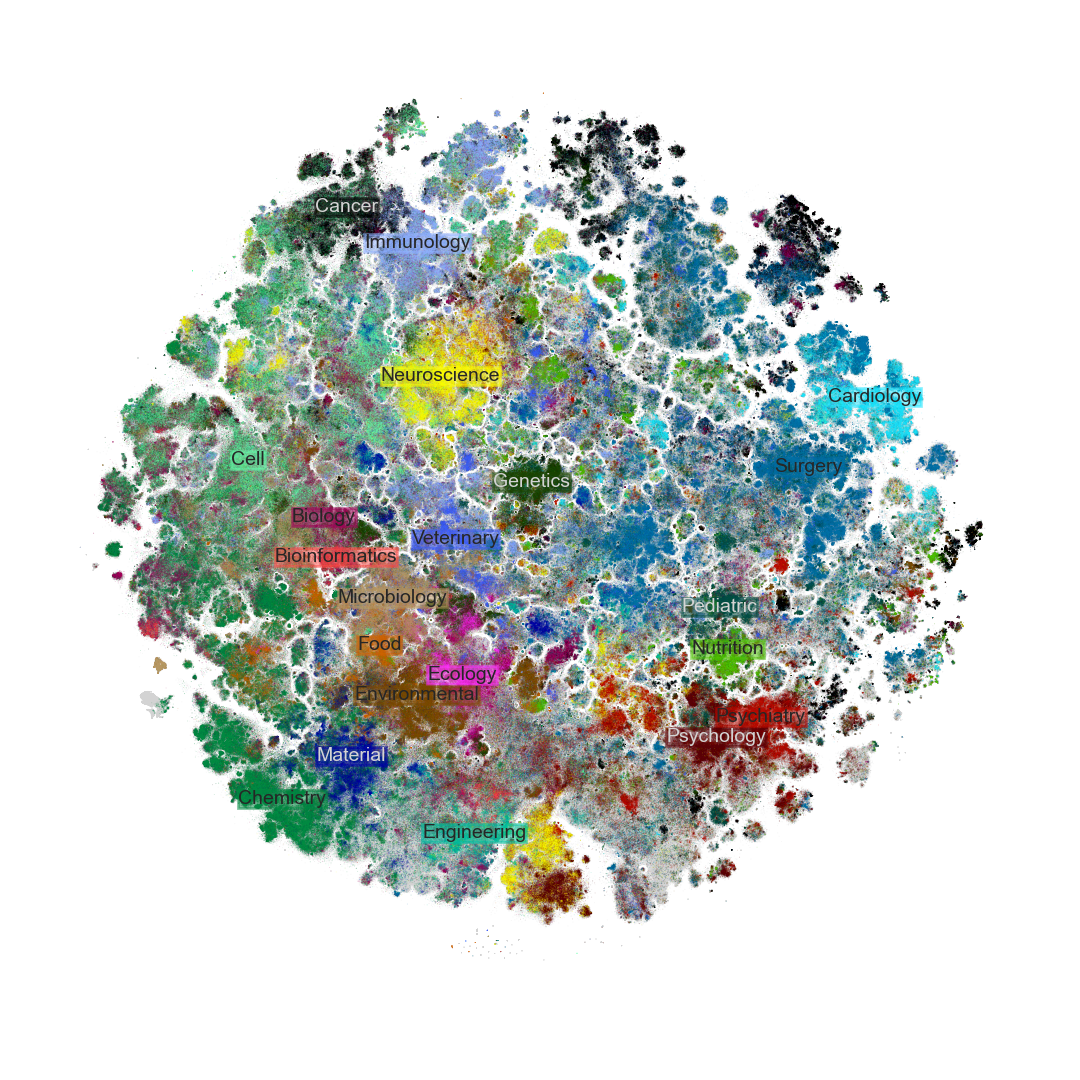

In [72]:
%%time

tsne=tsne_annealing_exgg_1_n_iter_10000

#plot the embedding
plot_with_labels(words_capital,chosen_colors,tsne,automatic_colors, dpi=200)

plt.xlim(-400,430)
plt.ylim(bottom=-450)

plt.xticks([])
plt.yticks([])
sns.despine(bottom=True, left=True)
plt.tight_layout()


#save
plt.savefig("figures/fig_A1.png", bbox_inches='tight')

# Fig A2

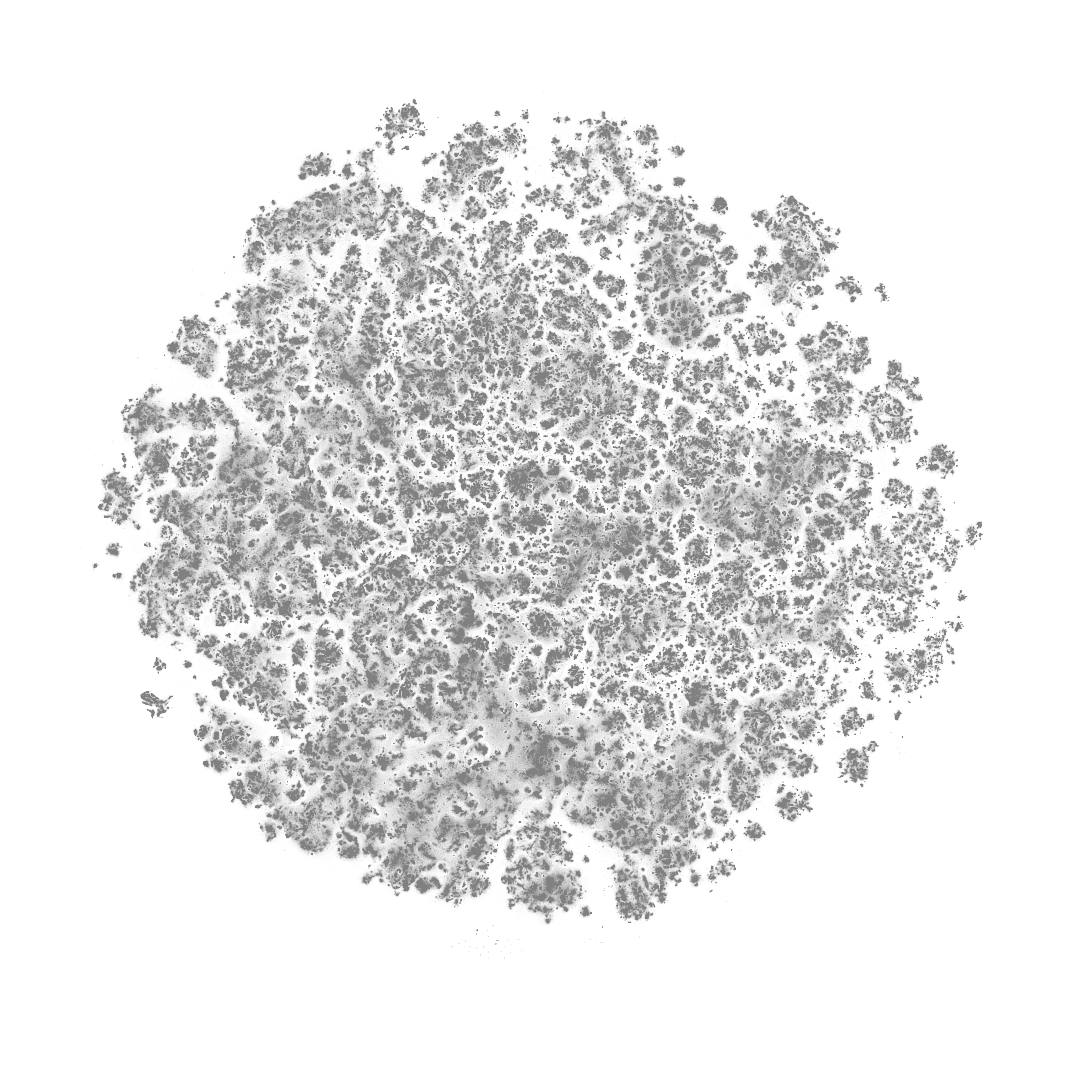

In [14]:
#Plot 
%matplotlib inline 
tsne=tsne_annealing_exgg_1_n_iter_10000
fig1=plt.figure(figsize=(5.5, 5.5),dpi=200)
plt.scatter(tsne[:,0],tsne[:,1],s=0.5,c='grey',marker='.',linewidths=None,ec='None', alpha=0.01, rasterized=True)
plt.axis('equal')
plt.xlim(-400,430)
plt.ylim(bottom=-450)
plt.grid()
plt.xticks([])
plt.yticks([])
sns.despine(bottom=True, left=True)
plt.tight_layout()

plt.savefig("figures/fig_A2.png", bbox_inches='tight')

# Fig A3

<ipython-input-17-89ee7e702823>:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


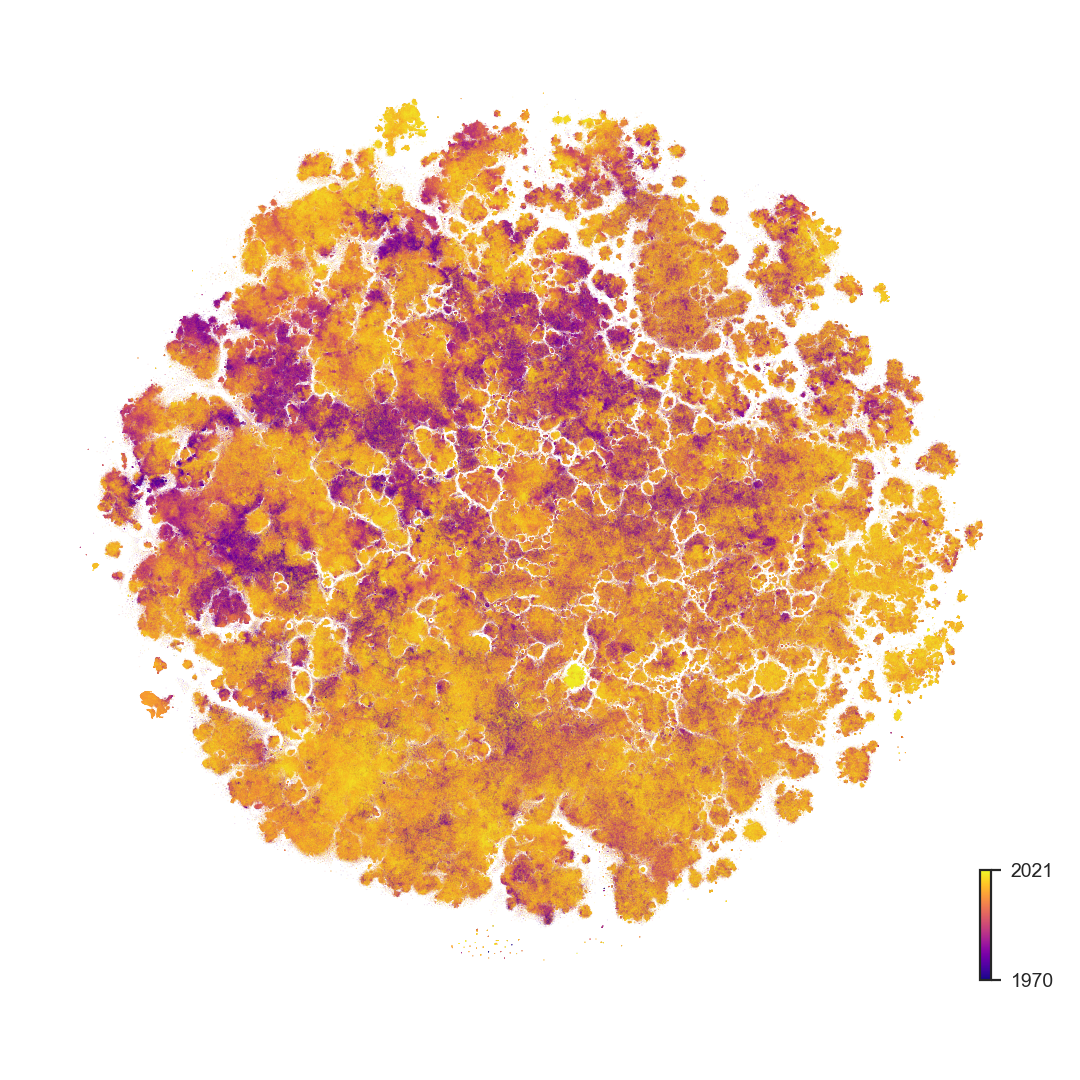

In [17]:
#Plot 
%matplotlib inline 

tsne=tsne_annealing_exgg_1_n_iter_10000
fig1 =plt.figure(figsize=(5.5, 5.5),dpi=200)

reorder = np.random.permutation(tsne.shape[0])#[:100]
plt.scatter(tsne[reorder][:,0], tsne[reorder][:,1],s=0.5, c=colors_per_year[reorder],cmap='plasma', alpha=0.2, marker='.',linewidths=None,ec='None', rasterized=True)

heatmap = plt.scatter([], [], c=[], cmap='plasma')

plt.axis('equal')
plt.xlim(-400,430)
plt.ylim(bottom=-450)
plt.xticks([])
plt.yticks([])

cax = fig1.add_axes([0.9,0.1,0.01,.1])
cbar = fig1.colorbar(heatmap, cax=cax, shrink=0.1)
cbar.set_alpha(1)
cbar.ax.get_yaxis().set_ticks([0,1])
cbar.ax.get_yaxis().set_ticklabels(['1970','2021'])
cbar.ax.tick_params(labelsize=7)


sns.despine(bottom=True, left=True)
plt.tight_layout()

plt.savefig("figures/fig_A3.png", bbox_inches='tight')

# Fig 1

Disclaimer: for some reason in the preview of this figure panel b appears empty. However, in the saved version it appears correctly.

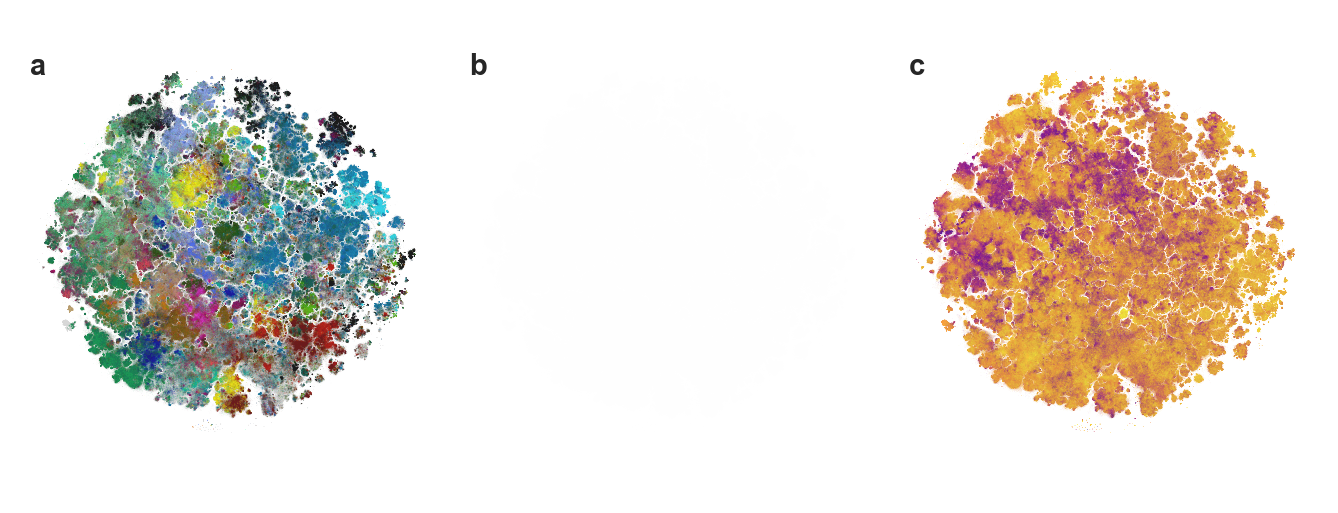

In [75]:
%matplotlib inline


# plot it
fig = plt.figure(figsize=(5.5,2), dpi=300)
gs = gridspec.GridSpec(1,3)


##exgg=1
tsne=tsne_annealing_exgg_1_n_iter_10000
#plot
ax0 = plt.subplot(gs[:,0])
ax0.scatter(tsne[:,0][automatic_colors=='lightgrey'],tsne[:,1][automatic_colors=='lightgrey'],s=0.05,c='lightgrey', alpha=0.2, marker='.',linewidths=None,ec='None', rasterized= True)
ax0.scatter(tsne[:,0][automatic_colors!='lightgrey'],tsne[:,1][automatic_colors!='lightgrey'],s=0.05,c=automatic_colors[automatic_colors!='lightgrey'],alpha=0.2, marker='.',linewidths=None, ec='None',rasterized= True)
#extra
ax0.text(0,0.9, string.ascii_lowercase[0], transform=ax0.transAxes, size=7, weight='bold')
ax0.axis('equal')
ax0.set_axis_off()
ax0.set_xlim(-400,430)
ax0.set_ylim(bottom=-450) 



##grey
#plot
ax1 = plt.subplot(gs[:,1])
ax1.scatter(tsne[:,0],tsne[:,1],s=0.05,c='grey',marker='.',linewidths=None,ec='None', alpha=0.01, rasterized=True)
ax1.text(0,0.9, string.ascii_lowercase[1], transform=ax1.transAxes, size=7, weight='bold')
ax1.axis('equal')
ax1.set_axis_off()
ax1.set_xlim(-400,430)
ax1.set_ylim(bottom=-450) 




##years
#plot
ax2 = plt.subplot(gs[:,2])
reorder = np.random.permutation(tsne.shape[0])
ax2.scatter(tsne[reorder][:,0], tsne[reorder][:,1],s=0.05, c=colors_per_year[reorder],cmap='plasma', alpha=0.2, marker='.',linewidths=None,ec='None', rasterized=True)
# extra
ax2.text(0,0.9, string.ascii_lowercase[2], transform=ax2.transAxes, size=7, weight='bold')
ax2.axis('equal')
ax2.set_axis_off()
ax2.set_xlim(-400,430)
ax2.set_ylim(bottom=-450) 


plt.subplots_adjust(wspace=0.1)

plt.savefig("figures/fig_1.png", bbox_inches='tight')

# Fig A6

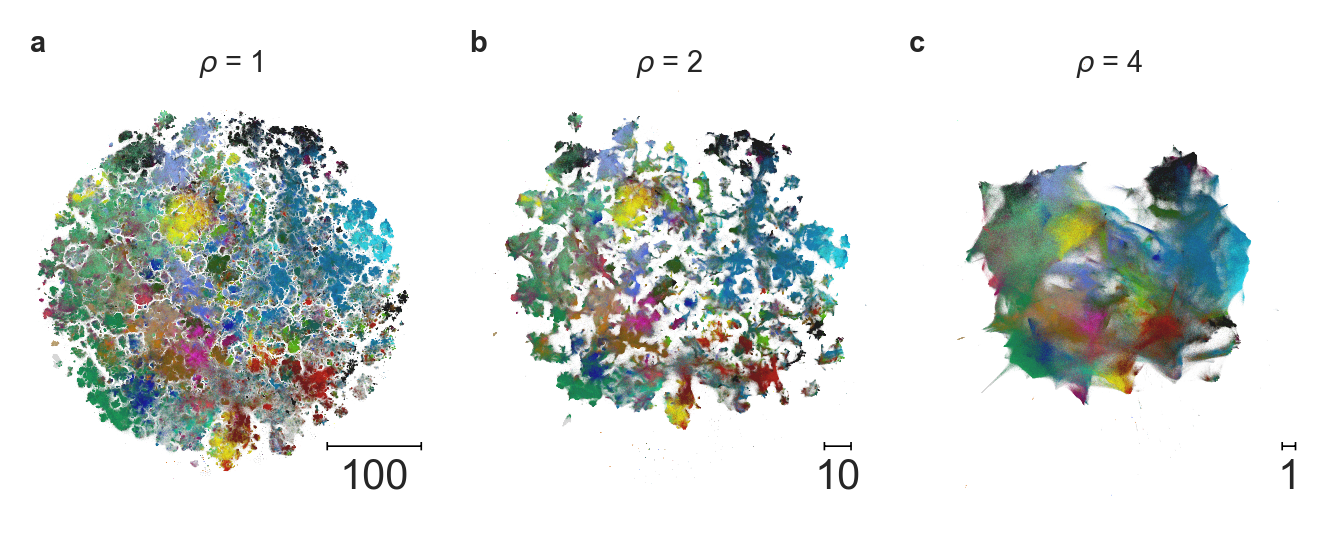

In [88]:
%matplotlib inline

# plot it
fig = plt.figure(figsize=(5.5,2), dpi=300)
gs = gridspec.GridSpec(1,3)


##exgg=1
index_2000 = [i for i, x in enumerate(np.array(iterations_exgg_1)==2000) if x]
tsne=Zs_array_annealing_exgg_1[index_2000[0]]

#plot
ax0 = plt.subplot(gs[:,0])
ax0.scatter(tsne[:,0][new_colors=='lightgrey'],tsne[:,1][new_colors=='lightgrey'],s=0.05,c='lightgrey', alpha=0.2, marker='.',linewidths=None,ec='None', rasterized= True)
ax0.scatter(tsne[:,0][new_colors!='lightgrey'],tsne[:,1][new_colors!='lightgrey'],s=0.05,c=new_colors[new_colors!='lightgrey'],alpha=0.2, marker='.',linewidths=None, ec='None',rasterized= True)
#extra
ax0.text(0,1, string.ascii_lowercase[0], transform=ax0.transAxes, size=7, weight='bold')
ax0.set_title(r'$\rho$ = 1', fontsize=7, y=0.9)
ax0.axis('equal')
ax0.set_axis_off()
ax0.set_xlim(-200,225)
ax0.set_ylim(-200,225) 
add_scalebar_frac(ax0) 



##exgg=2
tsne=tsne_exgg_2

#plot
ax1 = plt.subplot(gs[:,1])
ax1.scatter(tsne[:,0][new_colors=='lightgrey'],tsne[:,1][new_colors=='lightgrey'],s=0.05,c='lightgrey', alpha=0.2, marker='.',linewidths=None,ec='None',rasterized= True)
ax1.scatter(tsne[:,0][new_colors!='lightgrey'],tsne[:,1][new_colors!='lightgrey'],s=0.05,c=new_colors[new_colors!='lightgrey'],alpha=0.2, marker='.',linewidths=None,ec='None',rasterized= True)#extra
ax1.text(0,1, string.ascii_lowercase[1], transform=ax1.transAxes, size=7, weight='bold')
ax1.set_title(r'$\rho$ = 2', fontsize=7, y=0.9)
ax1.axis('equal')
ax1.set_axis_off()
ax1.set_xlim(-75,75)
ax1.set_ylim(-75,75)
add_scalebar_frac(ax1) 



##exgg=4
tsne=tsne_exgg_4

#plot
ax2 = plt.subplot(gs[:,2])
ax2.scatter(tsne[:,0][new_colors=='lightgrey'],tsne[:,1][new_colors=='lightgrey'],s=0.05,c='lightgrey', alpha=0.2, marker='.',linewidths=None,ec='None',rasterized= True)
ax2.scatter(tsne[:,0][new_colors!='lightgrey'],tsne[:,1][new_colors!='lightgrey'],s=0.05,c=new_colors[new_colors!='lightgrey'],alpha=0.2, marker='.',linewidths=None,ec='None',rasterized= True)
#extra
ax2.text(0,1, string.ascii_lowercase[2], transform=ax2.transAxes, size=7, weight='bold')
ax2.set_title(r'$\rho$ = 4', fontsize=7, y=0.9)
ax2.axis('equal')
ax2.set_axis_off()
ax2.set_xlim(-15,15)
ax2.set_ylim(-15,15) 
add_scalebar_frac(ax2) 


plt.subplots_adjust(wspace=0.1)
plt.savefig("figures/fig_A6.png", bbox_inches='tight')